In [2]:
import os
os.chdir('..')
import h5py
import config
import numpy as np
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.geotif_io import readTiff
from utils.transform_xy import coor2coor


In [3]:
path_img = config.root + '/data/rs_img/pine_island_S3A_20180207T115228_20180207T115528.tif'
s3_img, s3_img_info = readTiff(path_img)
print(s3_img_info)


{'geoextent': (-1741002.5304, -1437153.6139, -380178.3167, -165679.325), 'geotrans': (-1741002.5304, 295.8606781888998, 0.0, -165679.325, 0.0, -295.8606782068966), 'geosrs': '3031', 'row': 725, 'col': 1027, 'bands': 3}


In [4]:
with h5py.File('data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_AD.h5','r') as f_c:
    print(f_c.keys())
    lon_ad = f_c['lon'][:]
    lat_ad = f_c['lat'][:]
    ti_ad = f_c['t_year'][:]
    zi_ad = f_c['h_elv'][:]

lon_proj, lat_proj = coor2coor('4326', '3031', lon_ad, lat_ad)


<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'lat', 'lon', 'quality_summary', 'rgt', 'spot', 't_year']>


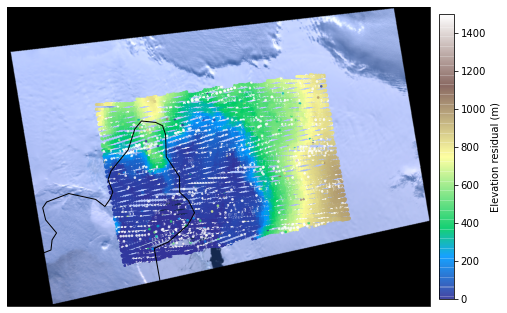

In [6]:
# fig = plt.figure(figsize=(8,6))
# ax = plt.axes(projection=ccrs.SouthPolarStereo())
# imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
# plt.scatter(lon_proj[::100], lat_proj[::100], s=3, c=zi_ad[::100], \
#                                     alpha=.7, cmap='terrain')
# plt.clim([0,1500])
# plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation residual (m)')
# ax.coastlines('50m')


### 3-D interpolation: result in a 3-d interpolation map (map.shape->[row, col, band]). 

In [13]:
# !python utils_main/points2cube.py -h


usage: points2cube.py [-h] [-d dx dy dt] [-r radius] [-a alpha_d alpha_t]
                      [-p epsg_num] [-s n_sample] [-c filter_dxy thres max]
                      [-v x y z t s]
                      ifile [ifile ...] ofile [ofile ...]

Spatio-temporal interpolation of irregular data

positional arguments:
  ifile                 name of input file (h5-format)
  ofile                 name of ouput file (h5-format)

optional arguments:
  -h, --help            show this help message and exit
  -d dx dy dt           resolution for 3-d grid (km, and month)
  -r radius             search radius (km)
  -a alpha_d alpha_t    spatial and temporal corr. length (km and months)
  -p epsg_num           EPSG proj number (AnIS=3031, GrIS=3413)
  -s n_sample           sample every n:th point in dataset
  -c filter_dxy thres max
                        dim. of filter in km, sigma thres and max-value
  -v x y z t s          name of varibales in the HDF5-file


In [15]:
# !python utils_main/points2cube.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_AD.h5 data/icesat2/land_ice_antarctic/preprocessed/pineisland_data_cube.h5 -d 2 2 2 \
# -r 3 -a 10 0.25 -p 3031 -c 10 3 1500 -v lon lat h_elv t_year dummy -s 1


parameters:
('ifile', ['data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_AD.h5'])
('ofile', ['data/icesat2/land_ice_antarctic/preprocessed/pineisland_data_cube.h5'])
('dxyt', [2.0, 2.0, 2.0])
('radius', [3.0])
('alpha', [10.0, 0.25])
('proj', ['3031'])
('n_sample', [1])
('filter', [10.0, 3.0, 1500.0])
('vnames', ['lon', 'lat', 'h_elv', 't_year', 'dummy'])
-> reading data ...
-> filtering data ...
-> creating kdtree ...
-> interpolating data ...
-> saving predictions to file...


In [16]:
with h5py.File('data/icesat2/land_ice_antarctic/preprocessed/pineisland_data_cube.h5','r') as f_c:
    print(f_c.keys())
    xi_cube = f_c['X'][:]
    yi_cube = f_c['Y'][:]
    ti_cube = f_c['time'][:]
    zi_cube = f_c['Z_interp'][:]
    print(zi_cube.shape)
    zirmse_cube = f_c['Z_rmse'][:]

lon_cube, lat_cube = coor2coor('3031', '4326', xi_cube, yi_cube)


<KeysViewHDF5 ['X', 'Y', 'Z_interp', 'Z_nobs', 'Z_rmse', 'epsg', 'time']>
(69, 91, 7)


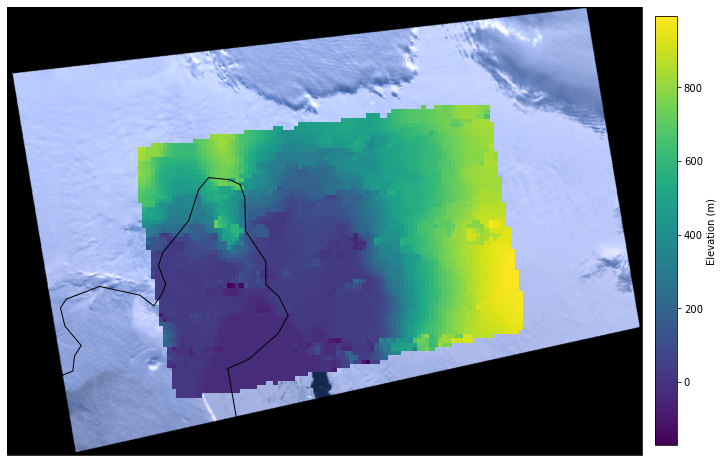

In [27]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.pcolormesh(xi_cube, yi_cube, zi_cube[:,:,5], cmap='viridis')
# plt.scatter(xi_cube.ravel(), yi_cube.ravel(), s=3, c=zi_cube[:,:,3].ravel(), \
                                                        # alpha=.7, cmap='terrain')
# plt.clim([800,1000])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')
